In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from matplotlib.ticker import MaxNLocator
from scipy.stats import pearsonr

sns.set_theme()
sns.set_context("paper")

### 1) Chain-of-Thought Results

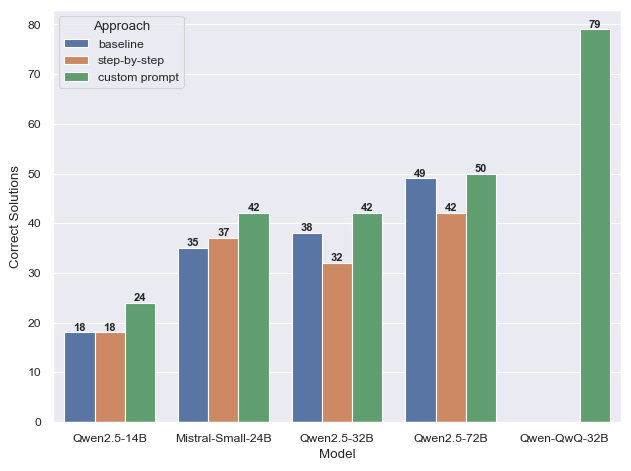

In [94]:
file_paths = [
    "../results/chain_of_thought/Qwen2.5-14B_step-by-step.csv",
    "../results/chain_of_thought/Qwen2.5-14B_baseline.csv",
    "../results/chain_of_thought/Qwen2.5-14B_custom prompt.csv",
    "../results/chain_of_thought/Mistral-Small-24B_baseline.csv",
    "../results/chain_of_thought/Mistral-Small-24B_custom prompt.csv",
    "../results/chain_of_thought/Qwen2.5-32B_baseline.csv",
    "../results/chain_of_thought/Qwen2.5-32B_step-by-step.csv",
    "../results/chain_of_thought/Qwen2.5-32B_custom prompt.csv",
    "../results/chain_of_thought/Qwen2.5-72B_baseline.csv",
    "../results/chain_of_thought/Qwen2.5-72B_step-by-step.csv",
    "../results/chain_of_thought/Qwen2.5-72B_custom prompt.csv",
    "../results/chain_of_thought/Qwen-QwQ-32B_custom prompt.csv"
]

data = []

for file in file_paths:
    df = pd.read_csv(file)
    llm_name = os.path.splitext(os.path.basename(file))[0].split("_")[0] 
    approach = os.path.splitext(os.path.basename(file))[0].split("_")[1] 
    count_correct = df.query("percentage_correct == 1")['task'].nunique()
    
    data.append({
        'Model': llm_name,
        'Approach': approach,
        'Correct Solutions': count_correct
    })

# this data was unfortunately lost, therefore manually added here    
data.append({
    'Model': 'Mistral-Small-24B',
    'Approach': 'step-by-step',
    'Correct Solutions': 37
})
    
plot_df = pd.DataFrame(data)
approach_order = ["baseline", "step-by-step", "custom prompt"]
plot_df['Approach'] = pd.Categorical(plot_df['Approach'], categories=approach_order, ordered=True)

ax = sns.barplot(x='Model', y='Correct Solutions', hue='Approach', data=plot_df)

for container in ax.containers:
    ax.bar_label(container, fontsize=8, fontweight='bold')

plt.tight_layout()

#plt.savefig('Reasoning_Performance.png', dpi=300)    
plt.show()

/tmp/ipykernel_1827/3181037673.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.9])  # Leave space at top for legend


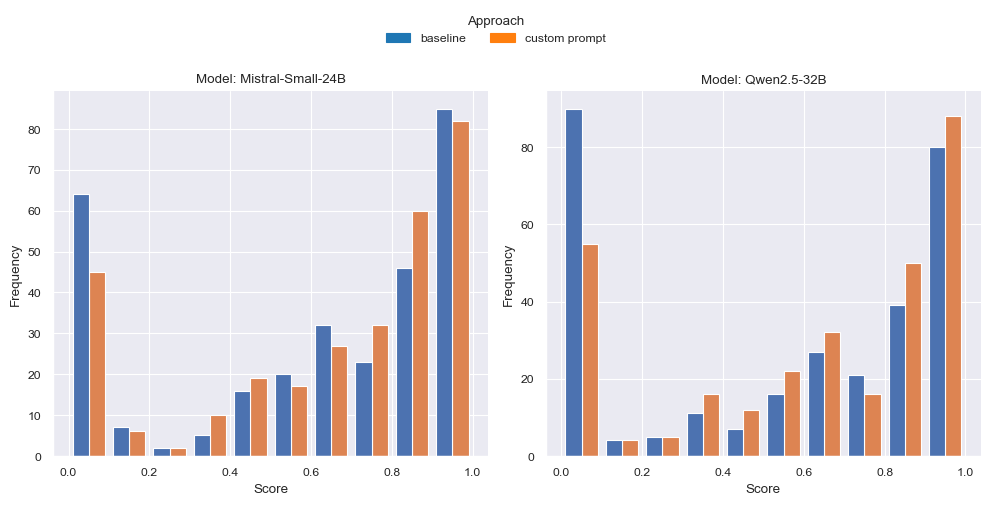

In [258]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

# Setup
file_paths = [
    "../results/chain_of_thought/Mistral-Small-24B_baseline.csv",
    "../results/chain_of_thought/Mistral-Small-24B_custom prompt.csv",
    "../results/chain_of_thought/Qwen2.5-32B_baseline.csv",
    "../results/chain_of_thought/Qwen2.5-32B_custom prompt.csv",
]

dfs = []
for file in file_paths:
    df = pd.read_csv(file)
    model = os.path.splitext(os.path.basename(file))[0].split("_")[0]
    approach = os.path.splitext(os.path.basename(file))[0].split("_")[1]
    df['model'] = model
    df['approach'] = approach
    dfs.append(df)

combined_df = pd.concat(dfs)

# Create the FacetGrid first
g = sns.FacetGrid(combined_df, col='model', height=5, sharex=False, sharey=False)

def plot_hist(data, **kwargs):
    sns.histplot(data=data, x='percentage_correct', bins=10, kde=False, multiple='dodge', hue='approach',alpha=1.0, shrink=0.8, **kwargs)
    plt.xlabel("Score")
    plt.ylabel("Frequency")

g.map_dataframe(plot_hist)
g.set_titles("Model: {col_name}")

# Add legend manually using g.fig (FacetGrid’s figure)
legend_ax = g.figure.add_axes([0.35, 0.92, 0.3, 0.08])  # [left, bottom, width, height]

labels = ['baseline', 'custom prompt']
colors = ['tab:blue', 'tab:orange']
handles = [mpatches.Patch(color=color, label=label) for label, color in zip(labels, colors)]

legend_ax.legend(handles=handles, loc='center', frameon=False, ncol=len(labels), title="Approach")
legend_ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.9])  # Leave space at top for legend
#plt.savefig('Score_Distribution.png', dpi=300)  
plt.show()


In [84]:
# calculate the average percentage_correct for each task to show how the reasoning prompt improved performance on average
(
    combined_df
    .groupby(['model', 'approach'])
    [['percentage_correct']]
    .agg('mean').round(2)
)

percentage_correct
model             approach                         
Mistral-Small-24B baseline                     0.60
                  custom prompt                0.65
Qwen2.5-32B       baseline                     0.54
                  custom prompt                0.62

### Output Tokens: Compare Reasoning Models vs. Non Reasoning

In [85]:
import json
from transformers import AutoTokenizer

# Load json-file
with open("../results/final_approach/transformation_rules_full.json", "r") as f:
    json_data = json.load(f)


# load tokenizer
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-3B-Instruct")

def get_token_stats_from_texts(texts, label):
    token_lengths = []

    for text in texts:
        if text is not None and isinstance(text, str):
            tokens = tokenizer.encode(text, add_special_tokens=False)
            token_lengths.append(len(tokens))

    if token_lengths:
        max_tokens = max(token_lengths)
        avg_tokens = sum(token_lengths) / len(token_lengths)
        total_tokens = sum(token_lengths)
    else:
        max_tokens = avg_tokens = total_tokens = 0

    return {
        "Source": label,
        "Max Tokens": max_tokens,
        "Average Tokens": round(avg_tokens, 2),
        "Total Tokens": total_tokens,
        "Counted Entries": len(token_lengths)
    }

# stats from json (reasoningmodel)
json_reasonings = [v.get("reasoning") for v in json_data.values()]
json_stats = get_token_stats_from_texts(json_reasonings, "JSON: reasoning")

# compare to non-reasoning models
df1 = pd.read_csv("../results/chain_of_thought/Mistral-Small-24B_custom prompt.csv")
df2 = pd.read_csv("../results/chain_of_thought/Qwen2.5-32B_custom prompt.csv")
df3 = pd.read_csv("../results/chain_of_thought/Qwen2.5-72B_custom prompt.csv")

df1_stats = get_token_stats_from_texts(df1["llm_full_answer"], "Mistral-Small-24B: answer_full")
df2_stats = get_token_stats_from_texts(df2["llm_full_answer"], "Qwen2.5-32B: answer_full")
df3_stats = get_token_stats_from_texts(df3["llm_full_answer"], "Qwen2.5-72B: answer_full")

# combine to final df
all_stats = [json_stats, df1_stats, df2_stats, df3_stats]
results_df = pd.DataFrame(all_stats)

print("\n=== Tokenization Summary ===")
print(results_df.to_string(index=False))

/home/daniel-mueller92/Projects/masters_thesis/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



=== Tokenization Summary ===
                        Source  Max Tokens  Average Tokens  Total Tokens  Counted Entries
               JSON: reasoning       28806        10400.58       1820101              175
Mistral-Small-24B: answer_full        6444         1918.81        575644              300
      Qwen2.5-32B: answer_full        3036          934.48        280343              300
      Qwen2.5-72B: answer_full        7377         1155.06        346517              300


### 2) Vision-Language Models' Results

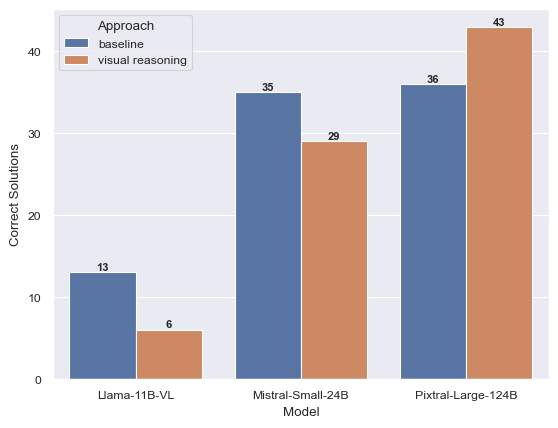

In [113]:
file_paths = [
    "../results/vl_models/Llama-11B-VL_baseline.csv",
    "../results/vl_models/Llama-11B-VL_visual reasoning.csv",
    "../results/vl_models/Mistral-Small-24B_visual reasoning.csv",
    "../results/chain_of_thought/Mistral-Small-24B_baseline.csv",
    "../results/vl_models/Pixtral-Large-124B_baseline.csv",
    "../results/vl_models/Pixtral-Large-124B_visual reasoning.csv"
]

data = []

for file in file_paths:
    df = pd.read_csv(file)
    llm_name = os.path.splitext(os.path.basename(file))[0].split("_")[0] 
    approach = os.path.splitext(os.path.basename(file))[0].split("_")[1] 
    count_correct = df.query("percentage_correct == 1")['task'].count()
    
    data.append({
        'Model': llm_name,
        'Approach': approach,
        'Correct Solutions': count_correct
    })

sns.set_theme()
sns.set_context("paper")


plot_df = pd.DataFrame(data)
ax = sns.barplot(x='Model', y='Correct Solutions', hue='Approach', data=plot_df)

for container in ax.containers:
    ax.bar_label(container, fontsize=8, fontweight='bold')

#plt.savefig('Visual_Reasoning.png', dpi=300)  
plt.show()

### 3) Program Synthesis Results

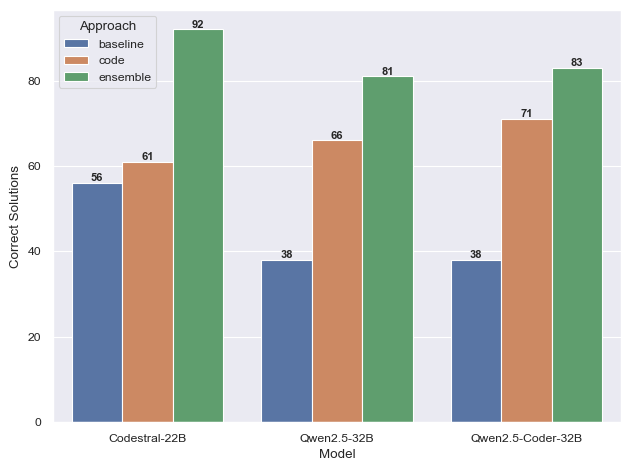

In [93]:
dataframe_pairs = [
    ["../results/program_synthesis/Codestral-22B_baseline.csv",
    "../results/program_synthesis/Codestral-22B_coding.csv"],
    ["../results/chain_of_thought/Qwen2.5-32B_baseline.csv",
    "../results/program_synthesis/Qwen2.5-32B_program synthesis.csv"],
    ["../results/program_synthesis/Qwen2.5-Coder-32B_baseline.csv",
    "../results/program_synthesis/Qwen2.5-Coder-32B_program synthesis.csv"],
]

data = []

for pair in dataframe_pairs:
    df1 = pd.read_csv(pair[0])
    df2 = pd.read_csv(pair[1])
    
    model = os.path.splitext(os.path.basename(pair[0]))[0].split("_")[0]
    baseline = set(df1.query("percentage_correct == 1")['task'].to_list())
    code = set(df2.query("average_percentage_correct == 1")['task'].to_list())
    extra = [task for task in baseline if task not in code]
    ensemble = len(extra) + len(code)
    
    approaches = ['baseline', 'code', 'ensemble']
    solutions = [len(baseline), len(code), ensemble]
    
    for approach, solution in zip(approaches, solutions):
        data.append({
            'Model': model,
            'Approach': approach,
            'Correct Solutions': solution
        })

plot_df = pd.DataFrame(data)
ax = sns.barplot(x='Model', y='Correct Solutions', hue='Approach', data=plot_df)

for container in ax.containers:
    ax.bar_label(container, fontsize=8, fontweight='bold')

plt.tight_layout()    
plt.savefig('Program_Synthesis_Performance.png', dpi=300)    
plt.show()

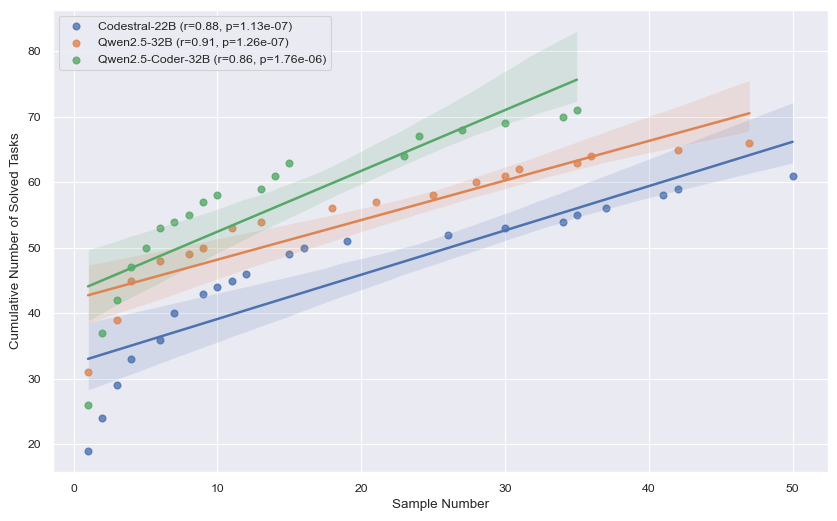

In [210]:
def analyze_data(df):
    """Finds cumulative solved tasks and their correlation to the number of samples drawn."""
    cumulative_solved = (
        df
        .query("average_percentage_correct == 1")
        .drop_duplicates(subset='task', keep='first')
        .groupby("sample_num")
        .size()
        .cumsum()
        .reset_index(name="solved_count")
    )
    corr, p_value = pearsonr(cumulative_solved["sample_num"], cumulative_solved["solved_count"])
    return cumulative_solved, corr, p_value

dataframes = {
    "Codestral-22B": pd.read_csv("../results/program_synthesis/Codestral-22B_coding.csv"),
    "Qwen2.5-32B": pd.read_csv("../results/program_synthesis/Qwen2.5-32B_program synthesis.csv"),
    "Qwen2.5-Coder-32B": pd.read_csv("../results/program_synthesis/Qwen2.5-Coder-32B_program synthesis.csv")
}

plt.figure(figsize=(10, 6))  

for model_name, df in dataframes.items():
    cumulative_solved, corr, p_value = analyze_data(df)
    sns.regplot(data=cumulative_solved, 
                x="sample_num", 
                y="solved_count", 
                marker='o', 
                label=f"{model_name} (r={corr:.2f}, p={p_value:.2e})",
                line_kws={"color": sns.color_palette()[list(dataframes.keys()).index(model_name)]},
                )

plt.xlabel("Sample Number")
plt.ylabel("Cumulative Number of Solved Tasks")
plt.legend()
#plt.tight_layout()
#plt.savefig('solved_tasks_vs_sample_num.png', dpi=300)    
plt.show()

### 4) Code Fixing and Feedback Loop

In [23]:
qwen_codefix = pd.read_csv("../results/program_synthesis/Qwen2.5-32B_self-debug.csv")
codestral_codefix = pd.read_csv("../results/program_synthesis/Codestral_self-debug.csv")

In [26]:
# Calculate number of solved tasks:
print(f"Qwen Coder: {qwen_codefix.query("average_percentage_correct == 1")['task'].nunique()}")
print(f"Codestral: {codestral_codefix.query("average_percentage_correct == 1")['task'].nunique()}")

Qwen Coder: 6
Codestral: 5


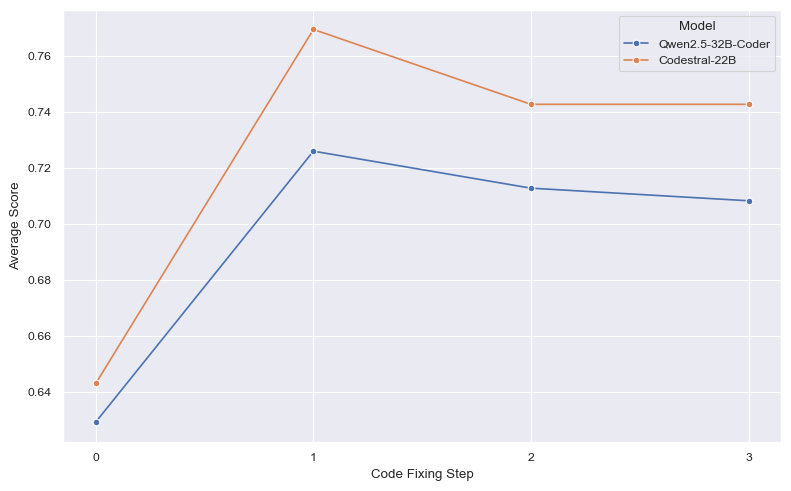

In [211]:

# show influence of code fixing step on answer quality

def process_pair(df_fix, df_og, label):
    # Apply Codestral-specific adjustment
    if label == "Codestral-22B":
        df_fix = df_fix.copy()
        df_fix['average_percentage_correct'] = df_fix['average_percentage_correct'] - 0.15
        df_fix['average_percentage_correct'] = df_fix['average_percentage_correct'].clip(lower=0)  # ensure non-negative scores

    # Step 1: Process fixing steps
    x = (
        df_fix
        .query("average_percentage_correct != 1 and num_attempt <= 3")
        .groupby(['task', 'num_attempt'])[['average_percentage_correct']]
        .max()
        .reset_index()
        .groupby('num_attempt')[['average_percentage_correct']]
        .mean()
        .reset_index()
    )

    # Step 2: Identify tasks
    solved_tasks = set(df_og.query("average_percentage_correct == 1.0")['task'].to_list())
    relevant_tasks = set(
        df_og.query("average_percentage_correct > 0.1 and average_percentage_correct != 1 and task not in @solved_tasks")["task"].to_list()
    )    

    # Step 3: Starting average score
    starting_average_score = (
        df_og
        .query("task in @relevant_tasks and \
                average_percentage_correct != 1 and \
                (average_percentage_correct > 0.1 or count_perfect_scores > 1)")
        .drop_duplicates(subset=["average_percentage_correct"], keep='first')
        .sort_values(["count_perfect_scores", "average_percentage_correct"], ascending=False)
        .groupby("task")
        .head(3)
        [['average_percentage_correct']]
        .mean()
    )

    # Step 4: Combine into single DataFrame
    new_row = {'num_attempt': 0, 'average_percentage_correct': starting_average_score['average_percentage_correct']}
    df_combined = pd.concat([pd.DataFrame([new_row]), x], ignore_index=True)
    df_combined['label'] = label  # for distinguishing in plot

    return df_combined

# Example input: list of (df_fix, df_og, label)
pairs = [
    (qwen_codefix, pd.read_csv("../results/program_synthesis/Qwen2.5-32B_program synthesis.csv"), "Qwen2.5-32B-Coder"),
    (codestral_codefix, pd.read_csv("../results/program_synthesis/Codestral-22B_coding.csv"), "Codestral-22B"),
]

# Process and combine all
all_data = pd.concat([process_pair(fix, og, label) for fix, og, label in pairs], ignore_index=True)

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=all_data, x='num_attempt', y='average_percentage_correct', hue='label', marker='o')

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # ensure integer ticks

plt.xlabel('Code Fixing Step')
plt.ylabel('Average Score')
plt.legend(title='Model')
plt.tight_layout()
#plt.savefig('code_fixing_steps.png', dpi=300)    
plt.show()

### 5) Combined Approaches Results

In [2]:
# calculate combined solution score and highlight individual contributions
# qwq
qwen_qwq_baseline = pd.read_csv("../results/chain_of_thought/Qwen-QwQ-32B_custom prompt.csv")
qwen_qwq_final = pd.read_csv("../results/final_approach/Qwen-QwQ-32B_final.csv")

# qwen-coder
qwen_coder_with_transformation_rules = pd.read_csv("../results/final_approach/Qwen2.5-Coder-32B_solved_with_reasoning_model.csv")
qwen_coder_without_transformation_rules = pd.read_csv("../results/program_synthesis/Qwen2.5-Coder-32B_program synthesis.csv")
qwen_coder_debug = pd.read_csv("../results/program_synthesis/Qwen2.5-32B_self-debug.csv")
qwen_32b_solved = pd.read_csv("../results/program_synthesis/Qwen2.5-32B_program synthesis.csv")

# find all solved tasks per step
# qwq
qwq_baseline_solved = set(qwen_qwq_baseline.query("percentage_correct == 1")['task'].to_list())
qwq_final_solved = set(qwen_qwq_final.query("percentage_correct == 1")['task'].to_list())

# qwen-coder
tasks_qwen_coder_noreason = set(qwen_coder_without_transformation_rules.query("average_percentage_correct == 1")['task'].to_list())
tasks_qwen_coder_reason = set(qwen_coder_with_transformation_rules.query("average_percentage_correct == 1")['task'].to_list())
tasks_debug = set(qwen_coder_debug.query("average_percentage_correct == 1")['task'].to_list())
tasks_base = set(qwen_32b_solved.query("average_percentage_correct == 1")['task'].to_list())

In [15]:
x = tasks_debug - qwq_final_solved
x

{'08ed6ac7', 'b6afb2da', 'e26a3af2', 'f76d97a5'}

In [274]:
# find out total tasks solved:
coding_solved = tasks_qwen_coder_reason.union(tasks_qwen_coder_noreason, tasks_debug)
total_solved = coding_solved.union(qwq_final_solved)
print(f"Total tasks solved all combined: {len(total_solved)}")

Total tasks solved all combined: 131


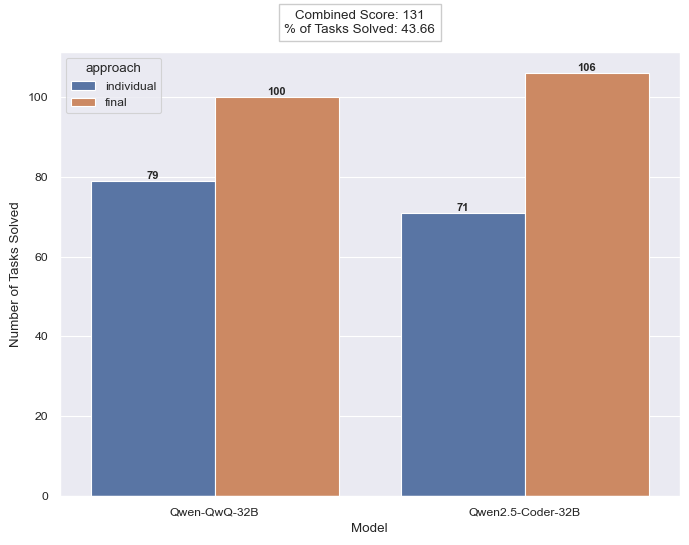

In [275]:
# construct dataframe for plotting
data = [
    {'model': 'Qwen-QwQ-32B', 'approach':'individual', 'tasks_solved': len(qwq_baseline_solved)},
    {'model': 'Qwen-QwQ-32B', 'approach':'final', 'tasks_solved': len(qwq_final_solved)},
    {'model': 'Qwen2.5-Coder-32B', 'approach':'individual', 'tasks_solved': len(tasks_qwen_coder_noreason)},
    {'model': 'Qwen2.5-Coder-32B', 'approach':'final', 'tasks_solved': len(tasks_qwen_coder_reason.union(tasks_qwen_coder_noreason,tasks_debug))},
]

df_plot = pd.DataFrame(data)


# Create bar plot
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.barplot(data=df_plot, x='model', y='tasks_solved', hue='approach')

for container in ax.containers:
    ax.bar_label(container, fontsize=8, fontweight='bold')



plt.subplots_adjust(top=0.85)
textstr = "Combined Score: 131\n% of Tasks Solved: 43.66"

# Use Seaborn's font family and context-sized font
font_family = plt.rcParams["font.family"]
font_size = plt.rcParams["font.size"]

# Place text box centered above the plot
fig.text(0.5, 0.92, textstr,
         ha='center', va='top',
         fontsize=font_size,
         fontfamily=font_family,
         bbox=dict(#boxstyle="round", 
                   facecolor='white', 
                   edgecolor='0.8', 
                   linewidth=1,
                   alpha=1))

# Add labels and title
ax.set_ylabel('Number of Tasks Solved')
ax.set_xlabel('Model')

#plt.tight_layout()
#plt.savefig('final_results.png', dpi=300)    
plt.show()
